In [1]:
import os
import pathlib
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image
import random

In [2]:
path = 'dataset2'
dir_names = ['cataract','normal' ]

for file in dir_names:
    dir = os.listdir(f"{path}/{file}")
    print(f"Data for {file} is {len(dir)}")

Data for cataract is 1038
Data for normal is 1074


In [3]:
output_dir = pathlib.Path('dataset2')
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

training_main = pathlib.Path('dataset2')

2012


In [4]:
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_main,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(150, 150),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_main,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(150, 150),
    batch_size=batch_size
)

Found 2112 files belonging to 2 classes.
Using 1690 files for training.
Found 2112 files belonging to 2 classes.
Using 422 files for validation.


In [5]:
IMG_SIZE = (150, 150)
IMG_SHAPE = IMG_SIZE + (3,)

# Load ResNet50 model pre-trained on ImageNet
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=IMG_SHAPE, pooling='max')

# Add custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(128, kernel_regularizer=regularizers.l2(0.070), activity_regularizer=regularizers.l1(0.008),
          bias_regularizer=regularizers.l1(0.008), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
output = Dense(2, activation='softmax')(x)  # Assuming 7 classes based on the directory structure

# Define the model
model = Model(inputs=base_model.input, outputs=output)

In [6]:
# Load the data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,  # Train for 25 epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add Early Stopping callback
)

Found 2112 images belonging to 2 classes.
Found 2112 images belonging to 2 classes.
Epoch 1/25
33/33 [==============================] - 63s 2s/step - loss: 0.8636 - accuracy: 0.6738 - val_loss: 0.4913 - val_accuracy: 0.7618
Epoch 2/25
33/33 [==============================] - 50s 2s/step - loss: 0.4465 - accuracy: 0.7836 - val_loss: 0.3640 - val_accuracy: 0.8428
Epoch 3/25
33/33 [==============================] - 43s 1s/step - loss: 0.3324 - accuracy: 0.8655 - val_loss: 0.2758 - val_accuracy: 0.8902
Epoch 4/25
33/33 [==============================] - 43s 1s/step - loss: 0.2730 - accuracy: 0.8892 - val_loss: 0.2413 - val_accuracy: 0.8954
Epoch 5/25
33/33 [==============================] - 43s 1s/step - loss: 0.2450 - accuracy: 0.9053 - val_loss: 0.2132 - val_accuracy: 0.9200
Epoch 6/25
33/33 [==============================] - 49s 2s/step - loss: 0.2281 - accuracy: 0.9086 - val_loss: 0.1853 - val_accuracy: 0.9361
Epoch 7/25
33/33 [==============================] - 46s 1s/step - loss: 0.19

In [7]:
# Evaluate the model
model.evaluate(validation_generator)

33/33 [==============================] - 12s 359ms/step - loss: 0.0514 - accuracy: 0.9815


[0.05144736170768738, 0.9815340638160706]

Found 2112 images belonging to 2 classes.
33/33 [==============================] - 12s 364ms/step
Classification Report
              precision    recall  f1-score   support

    cataract       1.00      0.96      0.98      1038
      normal       0.97      1.00      0.98      1074

    accuracy                           0.98      2112
   macro avg       0.98      0.98      0.98      2112
weighted avg       0.98      0.98      0.98      2112

Confusion Matrix
[[1001   37]
 [   2 1072]]


Text(95.72222222222221, 0.5, 'True Labels')

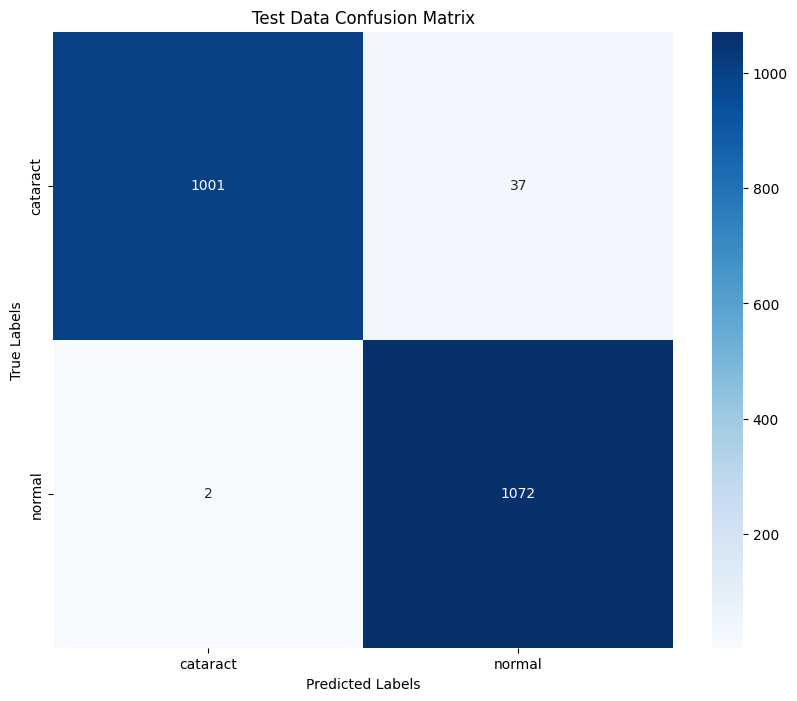

In [8]:
# Data testing
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='dataset2',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Predicting the test data
Y_pred_test = model.predict(test_generator, len(test_generator))
y_pred_test = np.argmax(Y_pred_test, axis=1)

# True labels from test generator
y_true_test = test_generator.classes

# Classification report and confusion matrix
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true_test, y_pred_test, target_names=target_names))

print('Confusion Matrix')
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)
print(conf_matrix_test)

# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

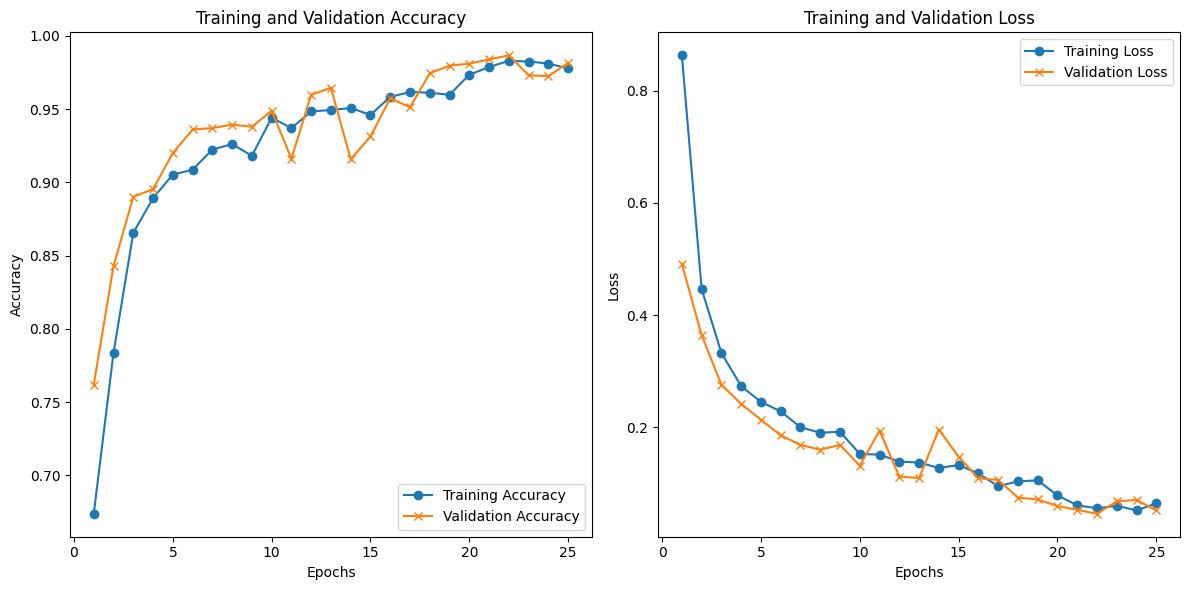

In [9]:
# Plotting accuracy and loss for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()